In [4]:
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import numpy as np
import json
import os

# # yolov5 result
---

In [37]:
path = '/data/NIA50/yolov5/runs/detect/sample_front/'
imgs = sorted(os.listdir(path))[:-1]

for img in imgs:
    display(Image.open(path+img))

# # avante_clip
---

In [36]:
box = [
    856.0033461808764,
    589.549110111358,
    140.71617039643877,
    142.40478412240202
]

In [53]:
def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    x = np.array(x).reshape(1, -1)
    y = np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    y = list(y.reshape(-1))
    return y


def xyxy2xywhn(x, w=1920, h=1200, clip=False, eps=0.0):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] normalized where xy1=top-left, xy2=bottom-right
    if clip:
        clip_boxes(x, (h - eps, w - eps))  # warning: inplace clip
    x = np.array(x).reshape(1, -1)
    y = np.copy(x)
    y[:, 0] = ((x[:, 0] + x[:, 2]) / 2) / w  # x center
    y[:, 1] = ((x[:, 1] + x[:, 3]) / 2) / h  # y center
    y[:, 2] = (x[:, 2] - x[:, 0]) / w  # width
    y[:, 3] = (x[:, 3] - x[:, 1]) / h  # height
    y = list(y.reshape(-1))
    return y


def kitti_to_yolo(label, x1, y1, x2, y2, image_w, image_h): # x1=x_min, y1=y_min, x2=x_max, y2=y_max
    return [label, ((x2 + x1)/(2*image_w)), ((y2 + y1)/(2*image_h)), (x2 - x1)/image_w, (y2 - y1)/image_h]

In [67]:
new_box = xywh2xyxy(box)
new_box


[785.645260982657, 518.346718050157, 926.3614313790958, 660.751502172559]

In [70]:
xywhn = xyxy2xywhn(new_box)
xywhn

[0.44583507613587314,
 0.4912909250927983,
 0.07328967208147859,
 0.11867065343533492]

In [71]:
kitti_to_yolo(7, new_box[0], new_box[1], new_box[2], new_box[3], 1920, 1200)

[7,
 0.44583507613587314,
 0.4912909250927983,
 0.07328967208147859,
 0.11867065343533492]

In [ ]:
0.253125 0.515 0.007292 0.013333

In [58]:
img.size

(1920, 1200)

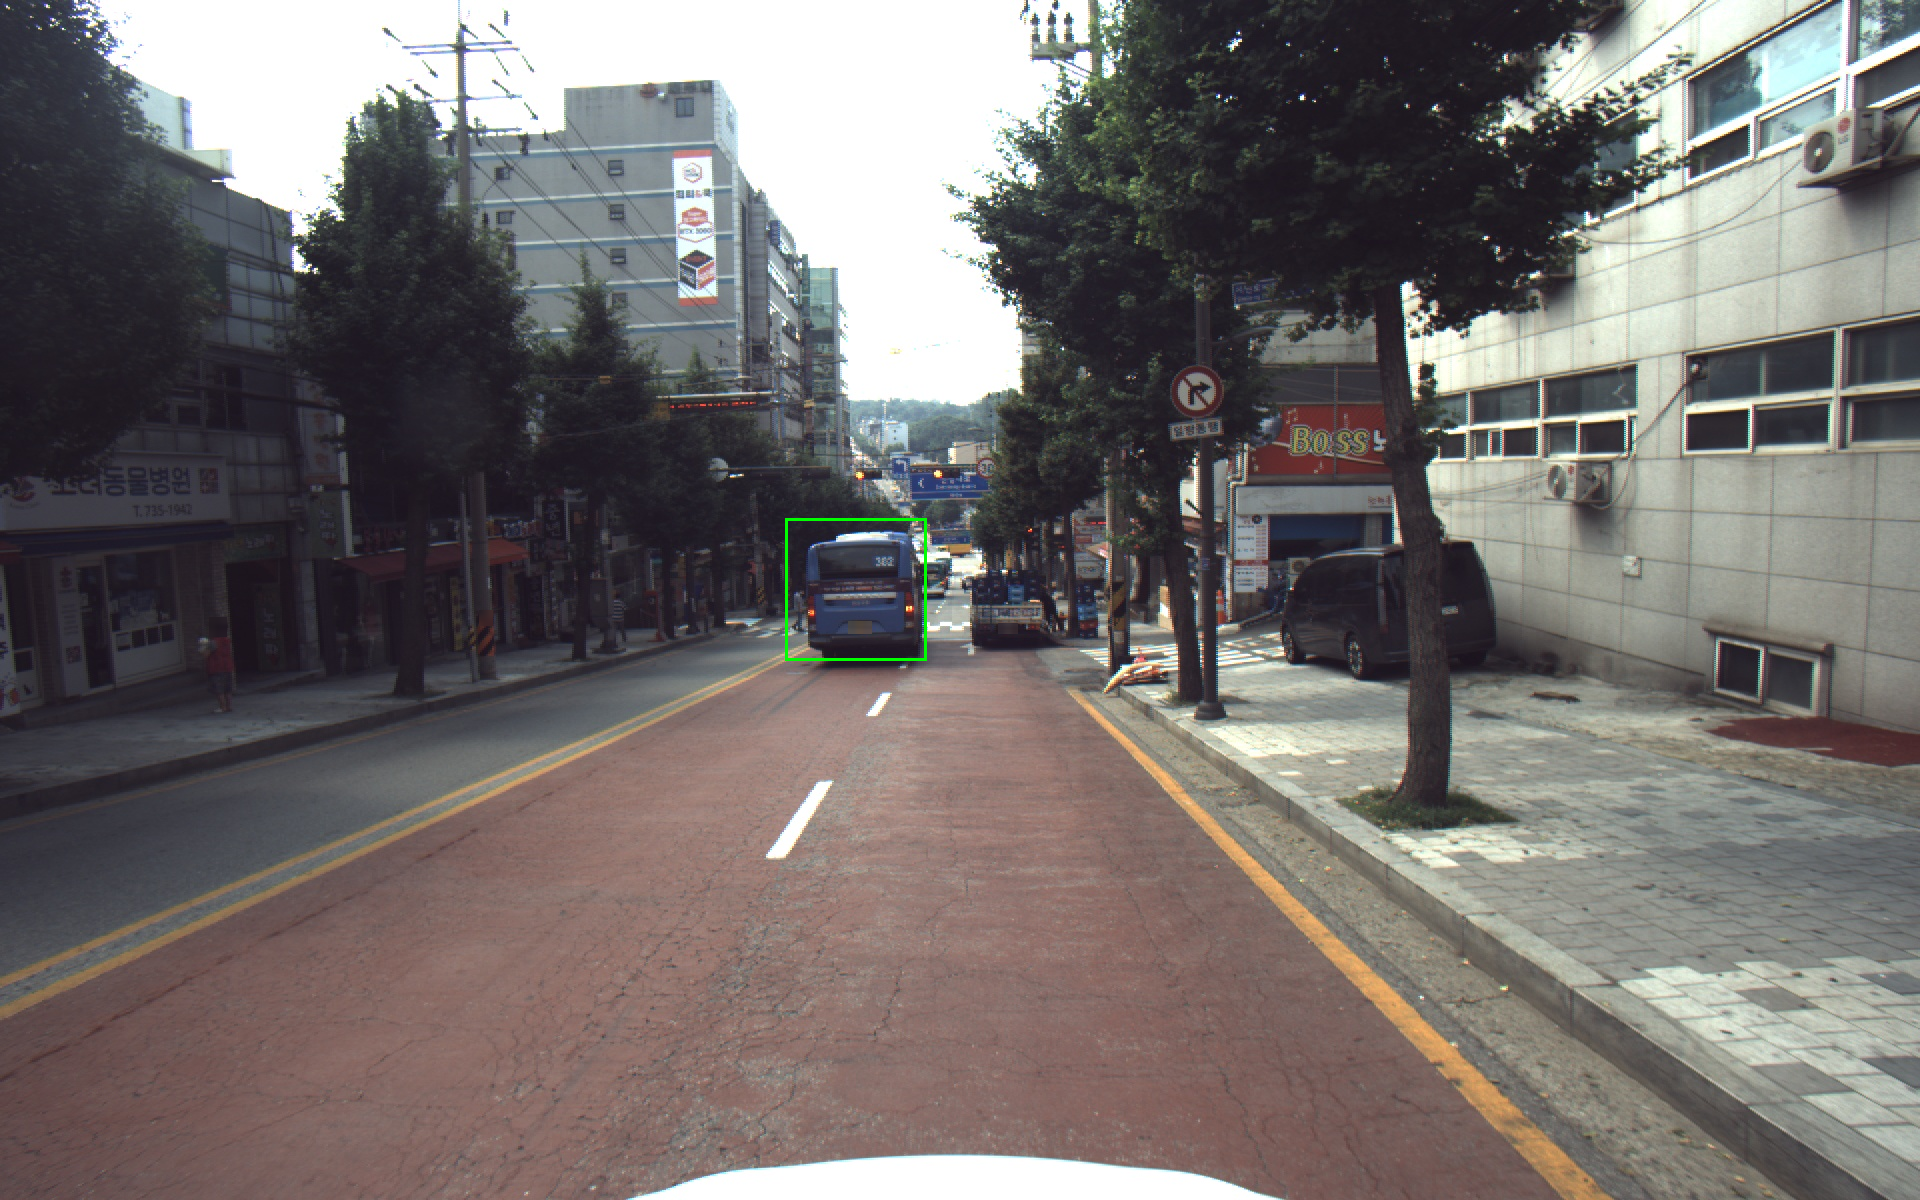

In [56]:
path = f'/data/NIA50/data/Avante_Clips/upload221005_220921/A_Clip_00355_05/Camera/CameraFront/blur/2-048_00355_CF_001.png'
img = Image.open(path).convert('RGB')
draw = ImageDraw.Draw(img)
color = (0, 255, 0)
draw.rectangle(new_box, outline = color, width = 3)

display(img)

# # 특수환경 자율주행 3D 이미지
---

## # 3D to 2D
---

In [ ]:
import os, numpy as np, sys, cv2
import random

from PIL import Image
from datasets.coordinate_transformation import compute_box_3dto2d

max_color = 30
score_threshold = -10000
width = 1242
height = 374

def draw_projected_box3d(image, qs, color=(255,255,255), thickness=2):
    ''' Draw 3d bounding box in image
        qs: (8,2) array of vertices for the 3d box in following order:
            1 -------- 0
           /|         /|
          2 -------- 3 .
          | |        | |
          . 5 -------- 4
          |/         |/
          6 -------- 7
    '''
    if qs is not None:
        qs = qs.astype(np.int32)
        for k in range(0,4):
           i,j=k,(k+1)%4
           image = cv2.line(image, (qs[i,0],qs[i,1]), (qs[j,0],qs[j,1]), color, thickness) # use LINE_AA for opencv3

           i,j=k+4,(k+1)%4 + 4
           image = cv2.line(image, (qs[i,0],qs[i,1]), (qs[j,0],qs[j,1]), color, thickness)

           i,j=k,k+4
           image = cv2.line(image, (qs[i,0],qs[i,1]), (qs[j,0],qs[j,1]), color, thickness)
    return image

def show_image_with_boxes(img2, bbox3d_tmp, image_path, color, img0_name, label, calib_file,line_thickness):
    # img2 = np.copy(img)
    box3d_pts_2d = compute_box_3dto2d(bbox3d_tmp, calib_file)
    tl = line_thickness or round(0.002 * (img2.shape[0] + img2.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    if box3d_pts_2d is not None:
        c1, c2 = (int(box3d_pts_2d[4, 0]), int(box3d_pts_2d[4, 1])),  (int(box3d_pts_2d[3, 0]), int(box3d_pts_2d[3, 1]))
    else:
        c1, c2 = (0,0), (0,0)
    color_tmp = color
    img2 = draw_projected_box3d(img2, box3d_pts_2d, color=color_tmp)
    # if box3d_pts_2d is not None:
    #     img2 = cv2.putText(img2, label, (int(box3d_pts_2d[4, 0]), int(box3d_pts_2d[4, 1]) - 8),
    #                        cv2.FONT_HERSHEY_TRIPLEX, 0.5, color=color_tmp)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(str(label), 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img2, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img2, str(label), (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    cv2.imwrite(image_path + "\\" + "{}.png".format(img0_name), img2)

    # img.save(save_path)
    # print('--')